In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
    
    def encoder(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample epsilon
        return mu + eps * std
    
    def decoder(self, z):
        h = torch.relu(self.fc2(z))
        x_recon = torch.sigmoid(self.fc3(h))  # Use sigmoid for normalized outputs
        return x_recon
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [12]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss (how much the latent distribution deviates from N(0,1))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD


In [13]:
def train(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Flatten image data to vectors
        data = data.view(data.size(0), -1).to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    average_loss = train_loss / len(train_loader.dataset)
    print(f'**** Average training loss: {average_loss:.4f} ****')


In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_reconstructions(model, test_loader, device):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        # Grab a batch of data
        data, _ = next(iter(test_loader))
        data = data.view(data.size(0), -1).to(device)  # Assuming MNIST (flatten 28x28 images)
        recon_batch, _, _ = model(data)

        # Reshape for visualization (convert flat vector back to image)
        data = data.view(-1, 28, 28).cpu()
        recon_batch = recon_batch.view(-1, 28, 28).cpu()

        n = 8  # number of images to visualize
        plt.figure(figsize=(16, 4))
        for i in range(n):
            # Original images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[i], cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title("Original")

            # Reconstructed images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_batch[i], cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title("Reconstruction")
        plt.show()

# Example usage:
# visualize_reconstructions(model, test_loader, device)


In [15]:
def sample_images(model, device, latent_dim, num_images=16):
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from a standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        samples = model.decoder(z)
        samples = samples.view(num_images, 28, 28).cpu()

        plt.figure(figsize=(4, 4))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            plt.imshow(samples[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Example usage:
# sample_images(model, device, latent_dim=20, num_images=16)


In [16]:
def visualize_latent_space(model, test_loader, device):
    import numpy as np
    from sklearn.manifold import TSNE

    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1).to(device)
            mu, _ = model.encoder(data)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.numpy())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(latent_vectors)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization using t-SNE")
    plt.show()

# Example usage:
# visualize_latent_space(model, test_loader, device)


In [17]:
def latent_interpolation(model, test_loader, device, num_interpolations=8):
    import numpy as np
    model.eval()
    # Get a batch from the test set
    data, _ = next(iter(test_loader))
    data = data.view(data.size(0), -1).to(device)
    
    with torch.no_grad():
        # Encode two images
        mu1, _ = model.encoder(data[0:1])
        mu2, _ = model.encoder(data[1:2])
        interpolated_images = []
        alphas = np.linspace(0, 1, num_interpolations)
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            interpolated = model.decoder(z)
            interpolated_images.append(interpolated.view(28, 28).cpu().numpy())
    
    plt.figure(figsize=(num_interpolations, 2))
    for i, img in enumerate(interpolated_images):
        ax = plt.subplot(1, num_interpolations, i + 1)
        plt.imshow(img, cmap='gray')
        ax.axis('off')
    plt.title("Latent Space Interpolation")
    plt.show()

# Example usage:
# latent_interpolation(model, test_loader, device, num_interpolations=8)


In [18]:
# Configuration and hyperparameters
epochs = 10
batch_size = 128
latent_dim = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader (for example: MNIST)
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model and optimizer
model = VAE(input_dim=784, hidden_dim=400, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train(model, train_loader, optimizer, device)


Epoch 1
**** Average training loss: 166.1969 ****
Epoch 2
**** Average training loss: 122.2230 ****
Epoch 3
**** Average training loss: 114.8222 ****
Epoch 4
**** Average training loss: 111.8465 ****
Epoch 5
**** Average training loss: 109.9977 ****
Epoch 6
**** Average training loss: 108.8672 ****
Epoch 7
**** Average training loss: 108.0376 ****
Epoch 8
**** Average training loss: 107.3979 ****
Epoch 9
**** Average training loss: 106.7918 ****
Epoch 10
**** Average training loss: 106.4230 ****


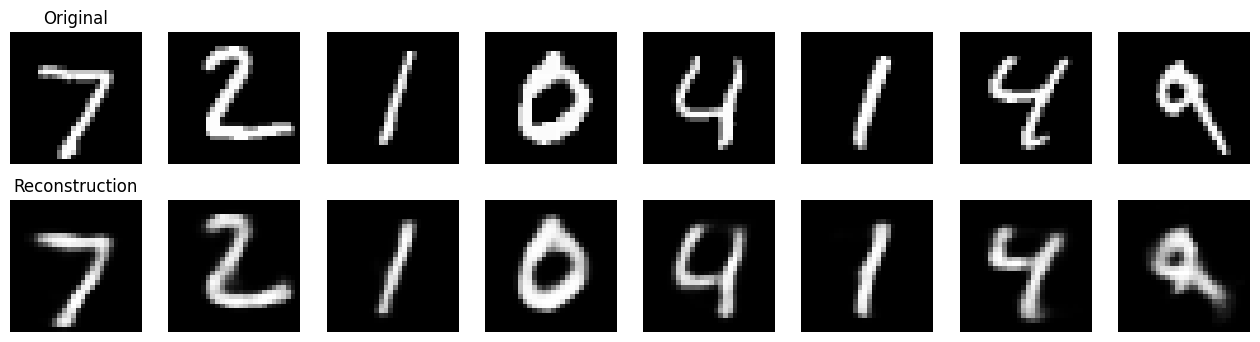

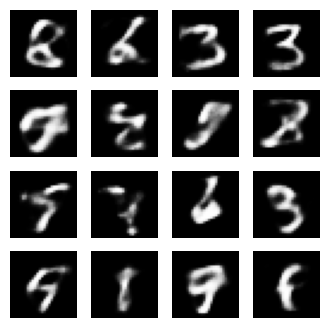

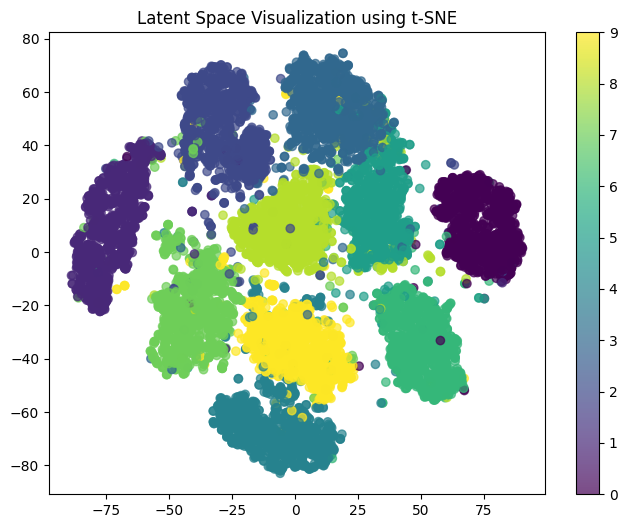

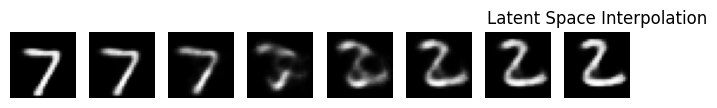

In [20]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

visualize_reconstructions(model, test_loader, device)
sample_images(model, device, latent_dim=20, num_images=16)
visualize_latent_space(model, test_loader, device)
latent_interpolation(model, test_loader, device, num_interpolations=8)
